In [1]:
from cv2.ximgproc import *
import cv2
import matplotlib.pyplot as plt
import skimage
import numpy as np
from sklearn import linear_model
import scipy.misc

In [2]:
class KSVD(object):
    def __init__(self, n_components=512, max_iter=30, tol=1e-6,
                 n_nonzero_coefs=None):
        """
        稀疏模型Y = DX，Y为样本矩阵，使用KSVD动态更新字典矩阵D和稀疏矩阵X
        :param n_components: 字典所含原子个数（字典的列数）
        :param max_iter: 最大迭代次数
        :param tol: 稀疏表示结果的容差
        :param n_nonzero_coefs: 稀疏度
        """
        self.dictionary = None
        self.sparsecode = None
        self.max_iter = max_iter
        self.tol = tol
        self.n_components = n_components
        self.n_nonzero_coefs = n_nonzero_coefs

    def _initialize(self, y):
        """
        用随机二阶单位范数初始化字典矩阵
        """
        shape=[64,self.n_components]
        #对每一列归一化为L2-norm
        self.dictionary = np.random.random(shape)
        for i in range(shape[1]):
            self.dictionary[:, i]=self.dictionary[:, i]/np.linalg.norm(self.dictionary[:, i])

    def _update_dict(self, y, d, x):
        """
        使用KSVD更新字典的过程
        """
        for i in range(self.n_components):
            index = np.nonzero(x[i, :])[0]
            if len(index) == 0:
                continue
            d[:, i] = 0
            r = (y - np.dot(d, x))[:, index]
            u, s, v = np.linalg.svd(r, full_matrices=False)
            d[:, i] = u[:, 0].T
            x[i, index] = s[0] * v[0, :]
        
        self.sparsecode = x
        return d, x


    def fit(self, img, y):
        """
        KSVD迭代过程
        """
        print(img.shape[1], type(img))

#         patch_num=int(img.size/64)
        
        #将图像按8*8的块转化列向量，合起来成为64*1024的矩阵
        #img保存原始图像转化的矩阵，y用于保存img减去列均值后的矩阵
#         y=np.zeros((8*8, patch_num))

#         patch_width = int(img.shape[1]/8) # 64
        
#         for patch_index in range(patch_num):
#             #按先行后列，将图片分解成32*32个8*8的小块并装换为列向量
#             r=int(int(patch_index/patch_width)*8)
#             c=int(int(patch_index%patch_width)*8)
#             patch=img[r:r+8, c:c+8].flat
#             y[:, patch_index]=patch

        #字典初始化
        self._initialize(y)
        for i in range(self.max_iter):
            #linear_model.orthogonal_mp 用法详见：
            #http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.orthogonal_mp.html
            x = linear_model.orthogonal_mp(self.dictionary, y, n_nonzero_coefs=self.n_nonzero_coefs)#OMP
            e = np.linalg.norm(y- np.dot(self.dictionary, x))
            print('第%s次迭代，误差为：%s' %(i, e))
            if e < self.tol:
                break
            self._update_dict(y, self.dictionary, x)

        return self.dictionary, self.sparsecode

In [8]:
#计算PSNR值
def psnr(A, B):
    if (A==B).all(): return 0
    return 10*np.log10(255*255.0/(((A.astype(np.float)-B)**2).mean()))

#将8*8块为列向量的矩阵还原为原矩阵
def patch_to_img(patchs, img_rows, img_cols):
    patch_num=patchs.shape[1]
    size=int(img_cols/8)
    img=np.zeros((img_rows, img_cols))
    for i in range(patch_num):
        r=int(int(i/size)*8)
        c=int(int(i%size)*8)
        img[r:r+8, c:c+8]=patchs[:, i].reshape((8, 8))
    return img

#将图像分割为8*8块作为列向量
def img_to_patch(img):
    patchs=np.zeros((8*8, 32*32))
    blocks_r=img.shape[0]/8
    blocks_c=img.shape[1]/8
    patch_num=blocks_r*blocks_c
    for i in range(patchs.shape[1]):
        #按先行后列，将图片分解成32*32个8*8的小块并装换为列向量
        r=int(int(i/blocks_r)*8)
        c=int(int(i%blocks_c)*8)
        patch=img[r:r+8, c:c+8].flat
        patchs[:, i]=patch
    return patchs

In [11]:
Jclock1 = cv2.imread("./images/Jclock1.png",0).astype(np.uint8)
print(Jclock1.shape)
Jclock1_y = img_to_patch(Jclock1)
print(Jclock1_y.shape)
#最大迭代次数设为20
ksvd = KSVD(max_iter=2)
dictionary, sparsecode = ksvd.fit(Jclock1, Jclock1_y)

(256, 256)
(64, 1024)
256 <class 'numpy.ndarray'>
第0次迭代，误差为：7.163198525348117
第1次迭代，误差为：6.32268607820476


83.48918357019073

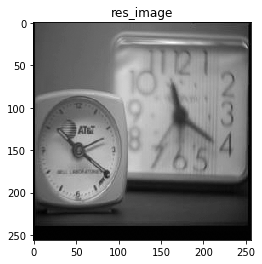

In [12]:
res = dictionary.dot(sparsecode)
res_image = patch_to_img(res, 256, 256)
plt.title('res_image')
plt.imshow(res_image.astype(np.uint8), plt.cm.gray)
psnr(Jclock1 ,res_image)